In [1]:
import numpy as np
import scipy.linalg
import scipy.special
import math
import sys
import matplotlib.pyplot as plt
import matplotlib.cm
import json
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
rcParams['font.size'] = 14

# Quartic EM Response: Current Density: Direct Numerics
[Adapted from David's higher-order-hamiltonian Jupyter notebook]

The following gives us the spectrum of effective continuum hamiltonians by truncating to finite-dimensional matrices. Set `trunc_dim` to the dimension of matrices we work with (50 seems to work fine).

## Hamiltonian Diagonalization

In [2]:
trunc_dim = 100

In [3]:
#initialize hamiltonian with zeroes
ham = np.matrix(np.zeros(shape=(trunc_dim,trunc_dim)),dtype=complex)
# Landau hamiltonian
h0 = np.diag(np.arange(trunc_dim)+0.5)
# squared ladder operators
f = np.vectorize(lambda x: math.sqrt(x*(x-1)))
g = np.vectorize(lambda x: math.sqrt((x+1)*(x+2)))
a2 = np.diag(f(np.arange(2,trunc_dim)),-2)
at2 = np.diag(g(np.arange(trunc_dim-2)),2)
# squared momenta
px2 = h0 - 0.5*(a2+at2)
py2 = h0 + 0.5*(a2+at2)

In [4]:
## Single Ladder Operators

f1 = np.vectorize(lambda x: math.sqrt(x))
g1 = np.vectorize(lambda x: math.sqrt(x+1))
                  
a1 = np.diag(f1(np.arange(1,trunc_dim)),-1)
at1 = np.diag(g1(np.arange(trunc_dim-1)),1)

py1 = -1/np.sqrt(2)*(a1+at1)

Let's add some functions that give us $p_x^{2n}$ and $p_y^{2n}$ recursively and store previous results

In [5]:
# returns matrix rep of px^(2n) using memoization to store results.
px2n_table = [0,px2]
def px2n(n):
    if(len(px2n_table)>n):
        return px2n_table[n]
    else:
        temp = px2n(n-1)@px2
        px2n_table.append(temp)
        return temp
    
# matrix rep of py^(2n)
py2n_table = [0,py2]
def py2n(n):
    if(len(py2n_table)>n):
        return py2n_table[n]
    else:
        temp = py2n(n-1)@py2
        py2n_table.append(temp)
        return temp

In [6]:
# Calculate odd powers of py

#matrix rep of py^(2n-1)
def pyn_odd(n):
    if((n%2)==1):
        if(n==1):
            return py1
        else:
            return py2n((n-1)//2) @ py1
    else:
        print('Error: n not odd')
    

Now we implement the hamiltonian $H_{\text{eff}}^{(n)} = \frac{1}{2n}\left(\pi_x^{2n} + \pi_y^{2n}\right)$

In [7]:
def p_power_Heff(n):
    return 0.5*(1/n)*(px2n(n) + py2n(n))

def find_evals_evec(n):
    q_evals,q_evecs =scipy.linalg.eigh(p_power_Heff(n))
    return q_evals,q_evecs



## Define and calculate matrix elements

In [8]:
def py_power(m):
    if(m==0):
        return np.zeros((trunc_dim,trunc_dim))
    elif((m%2)==0):
        return py2n(m//2)
    else:
        return pyn_odd(m)

In [9]:
def dcoeff(p,r):
    return (-1)**(p-r) * scipy.special.binom(p,p-r)

In [10]:
def matrix_elem(state_l, state_r, operator):
    return np.conjugate(state_l) @ operator @ state_r



## Calculate Current Density

In [11]:
def current_density_n_p_lam(n, p, lam, evals, evecs, mu_cutoff=20):
    
    mu_range = np.array([j for j in range(mu_cutoff)])
    mu_range = np.delete(mu_range, lam)
    
    rlist = range(p+1)
    
    current_density_out = 0
    
    for r in rlist:
        for mu in mu_range:
            current_density_out += dcoeff(p,r)*(matrix_elem(evecs[:,lam], evecs[:,mu], py_power(2*n-1+p-r))*
                                    matrix_elem(evecs[:,mu], evecs[:,lam], py_power(r))/
                                    (evals[lam]-evals[mu]))
    
    
    return -2*current_density_out

    

In [12]:
def write_current_density(n_max, p_max, lam_max, mu_cutoff=20):
    
    for n in range(1,n_max+1):
        
        evals,evecs=find_evals_evec(n)
        
        for p in range(1,p_max+1,2):
            
            filename = ("n"+str(n)+"_p"+str(p)+"_truncdim"+str(trunc_dim)+"_lam_max"+str(lam_max)
                   +"_mu_cutoff"+str(mu_cutoff)+"cp_table_DENSITY")
            
            output_data = []
            
            for lam in range(lam_max+1):
                output_data.append(current_density_n_p_lam(n, p, lam, evals, evecs, mu_cutoff))
                
            with open(filename, "w") as f:
                json.dump(output_data, f)
                
            
            

In [13]:
write_current_density(8,5,3)

In [14]:
write_current_density(8,5,3, mu_cutoff=50)

## Plots
### Import Data

In [15]:
def read_cp_table_DENSITY(n, p, lam_max=3, mu_cutoff=20, trunc_dim=100):
    
    filename = ("n"+str(n)+"_p"+str(p)+"_truncdim"+str(trunc_dim)+"_lam_max"+str(lam_max)
                   +"_mu_cutoff"+str(mu_cutoff)+"cp_table_DENSITY")
    
    with open(filename) as f:
        cp_table = json.load(f)
    
    return cp_table


### Plot single cp vs n

In [16]:

def plot_cp_vs_n_DENSITY(n_max, p, ylim_in=False, lam_max=3, mu_cutoff=20, trunc_dim=100):
    
    cp_table_full = []
    cp_table_Landau = []
    
    for n in range(1,n_max+1):
        cp_row = read_cp_table_DENSITY(n, p, lam_max=3, mu_cutoff=20, trunc_dim=100)
        cp_table_full.append(cp_row)
    
    for count in range(lam_max+1):
        cp_table_Landau.append([cp_table_full[0][count] for j in range(n_max)])
    
    
    cp_table_full = np.array(cp_table_full).T.tolist()
    
    nlist = [j for j in range(1,n_max+1)]
    
    colour_list=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    colour_list = matplotlib.cm.get_cmap('Dark2')
    plt.figure(figsize=(9,5))
    #plt.figure(figsize=(10,5))
    for count in range(lam_max+1):
        #plt.plot(nlist, cp_table_Landau[count], ':', color=colour_list(count), label=r'$|'+str(count)+'\\rangle$, LL')
        plt.plot(nlist, cp_table_full[count], 'o', color=colour_list(count), label=r'$|'+str(count)+'\\rangle$, $H^{(2n)}$')
    plt.legend(loc=5)
    plt.xlabel("n",fontsize=18)
    plt.xticks(fontsize=18)
    plt.ylabel("Coefficient",fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlim(0.75,n_max+3.0)
    if(ylim_in):
        plt.ylim(ylim_in[0],ylim_in[1])
    title_str = r"Current Density: $c_"+str(p)+"$, $\mu$ cutoff="+str(mu_cutoff)+", Trunc. dim.="+str(trunc_dim)
    plt.title(title_str)
    plt.savefig(title_str + ".pdf",pad_inches=0,bbox_inches='tight')
        
    

### c_1

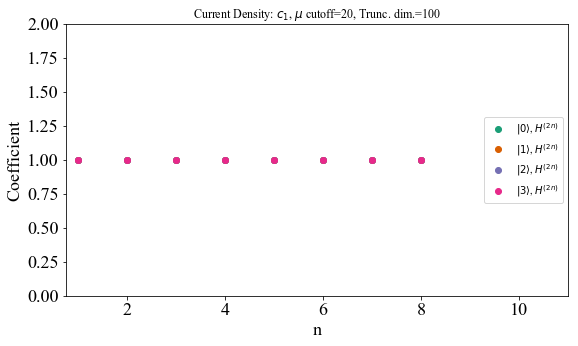

In [17]:
plot_cp_vs_n_DENSITY(8,1, ylim_in=[0,2])

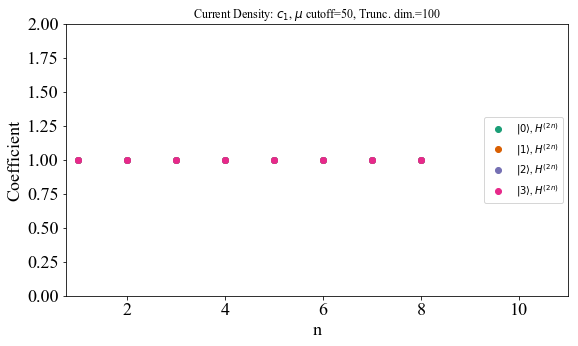

In [18]:
plot_cp_vs_n_DENSITY(8,1, mu_cutoff=50, ylim_in=[0,2])

### c_3

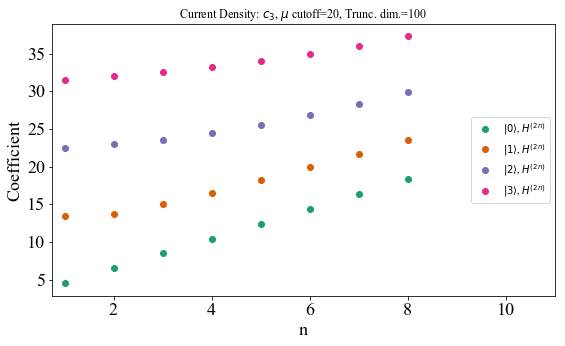

In [19]:
plot_cp_vs_n_DENSITY(8,3)

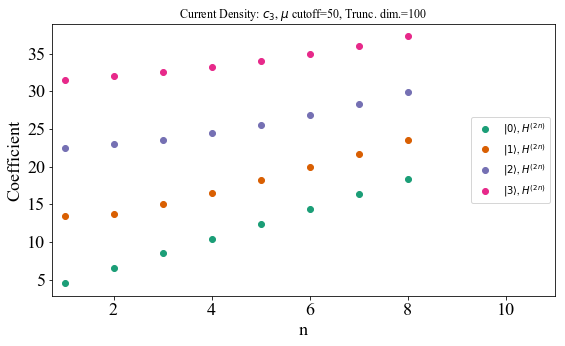

In [20]:
plot_cp_vs_n_DENSITY(8,3, mu_cutoff=50)

### c_5

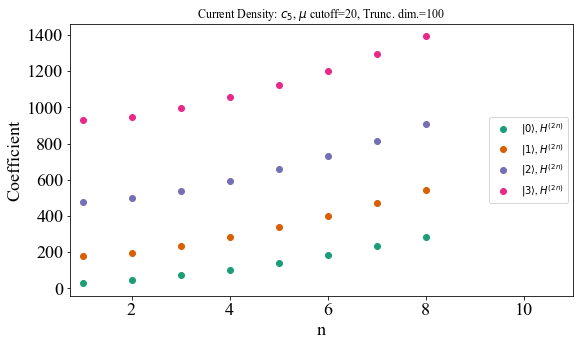

In [21]:
plot_cp_vs_n_DENSITY(8,5)

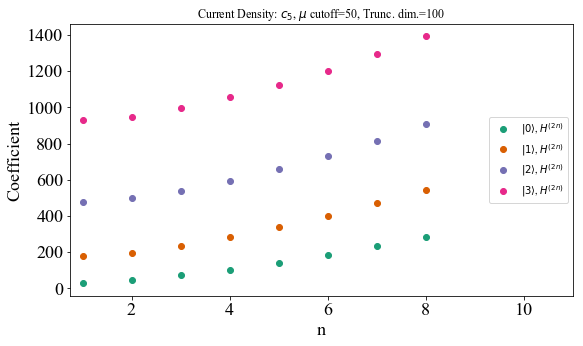

In [22]:
plot_cp_vs_n_DENSITY(8,5, mu_cutoff=50)